In [45]:
# activate project environment
using Pkg
Pkg.activate("C:\\Users\\Scuff\\OneDrive\\Course Documents\\Lobster Hatchery\\Code\\")

using RCall, DataFrames, Plots
plotlyjs()
theme(:ggplot2)
default(
    legend=:outertopright,
    # legend=:none,
    legend_title="Legend",
    legend_background_color=:white,
    linewidth=3,
    formatter=:plain,
    guidefontsize=18,
    tickfontsize=14,
    legendfontsize=14
    )

R"""
library(mizer)
library(mizerShelf)
"""
@rimport mizer

R"source('hatchery.R')"
function projectHatchery(params; t_max = 100, t_save=1, dt=0.1)
    rcall(R"projectHatchery", params, t_max = t_max, t_save = t_save, dt = dt)
end

  Activating project at `C:\Users\Scuff\OneDrive\Course Documents\Lobster Hatchery\Code`


projectHatchery (generic function with 1 method)

In [46]:
# define params we are using
params = R"NWMed_params"
params = mizer.steady(params);

┌ Warning: RCall.jl: Convergence was achieved in 1.5 years.
└ @ RCall C:\Users\Scuff\.julia\packages\RCall\Wyd74\src\io.jl:172


In [100]:
# determine more reasonable hatchery input by fraction of total number of mature
# individuals maturity
N_mat = mizer.getN(params, min_w=mizer.species_params(params)[:w_mat])

# number of individuals to add from hatchery as a % of N_mat, i.e. ratio=1 => 
# add one individual for every mature individual in population
ratio = 1
#! what is a sensible ratio? is this even a sensible way to scale?

hatchery_target = "Angular crab"
hatchery_params = DataFrame(species = hatchery_target, mu = 0.5, sigma = 0.1, annual_N=N_mat[hatchery_target]*ratio)
@rput hatchery_params

# define new hatchery time dependence function (default is constant 1)
R"""
hatchery_T = function(t) {
    # return(1 - sign(sin(2 * pi * t))) # square wave
    return(1)
}
""";

hatchery_params

Row,species,mu,sigma,annual_N
,String,Float64,Float64,Float64
1,Angular crab,0.5,0.1,0.00589927


In [101]:
baseline = mizer.project(params, t_max=30, t_save=0.2, dt=0.05)
hatchery = projectHatchery(params, t_max=30, t_save=0.2, dt=0.05)
;

## Shannon Index

The Shannon index (a.k.a. Shannon-Wiener diversity index) provides a metric for species diversity within an ecosystem. It is based on the Shannon entropy which provides a metric for the "amount of information" in a system (applications in information theory).

The Shannon index of an ecological system with species $i \in \mathcal{S}$ is given by
$$
H = - \sum p_i \log(p_i)
$$
where $p_i$ is the proportion of the total number of individuals for species $i$, i.e.
$$
p_i = \frac{n_i}{N}
$$
where $n_i$ is the number of individuals of species $i$ and $N = \sum n_i$ is the total number of individuals.

In [102]:
function shannon(N)
    n = filter(!iszero, N) # remove zeros (upsets log function)

    total = sum(n)
    p = n / total
    
    return - sum(p .* log.(p))
end

shannon (generic function with 1 method)

In [103]:
N_baseline = rcopy(mizer.getN(baseline))
H_baseline = shannon.(eachrow(N_baseline))
time_baseline = rcopy(mizer.getTimes(baseline))
;

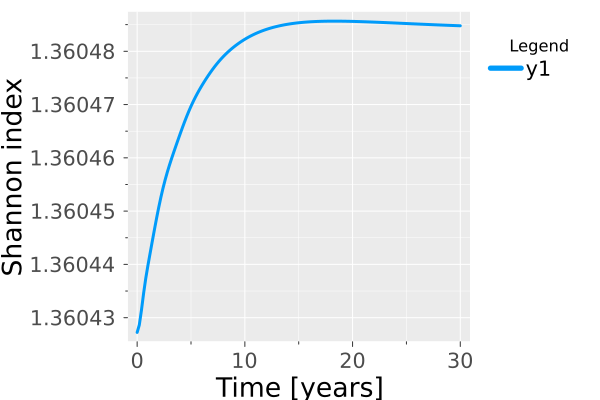

In [104]:
plot(
    time_baseline,
    H_baseline,
    yaxis = "Shannon index",
    xaxis = "Time [years]"
)

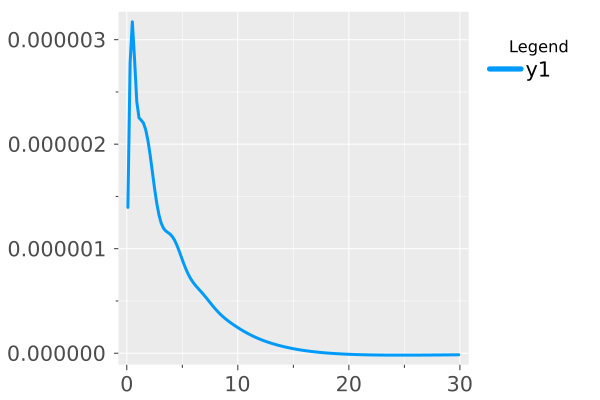

In [105]:
plot(time_baseline[1:end-1].+0.1, diff(H_baseline))

In [106]:
N_hatchery = rcopy(mizer.getN(hatchery))
H_hatchery = shannon.(eachrow(N_hatchery))
time_hatchery = rcopy(mizer.getTimes(hatchery))
;

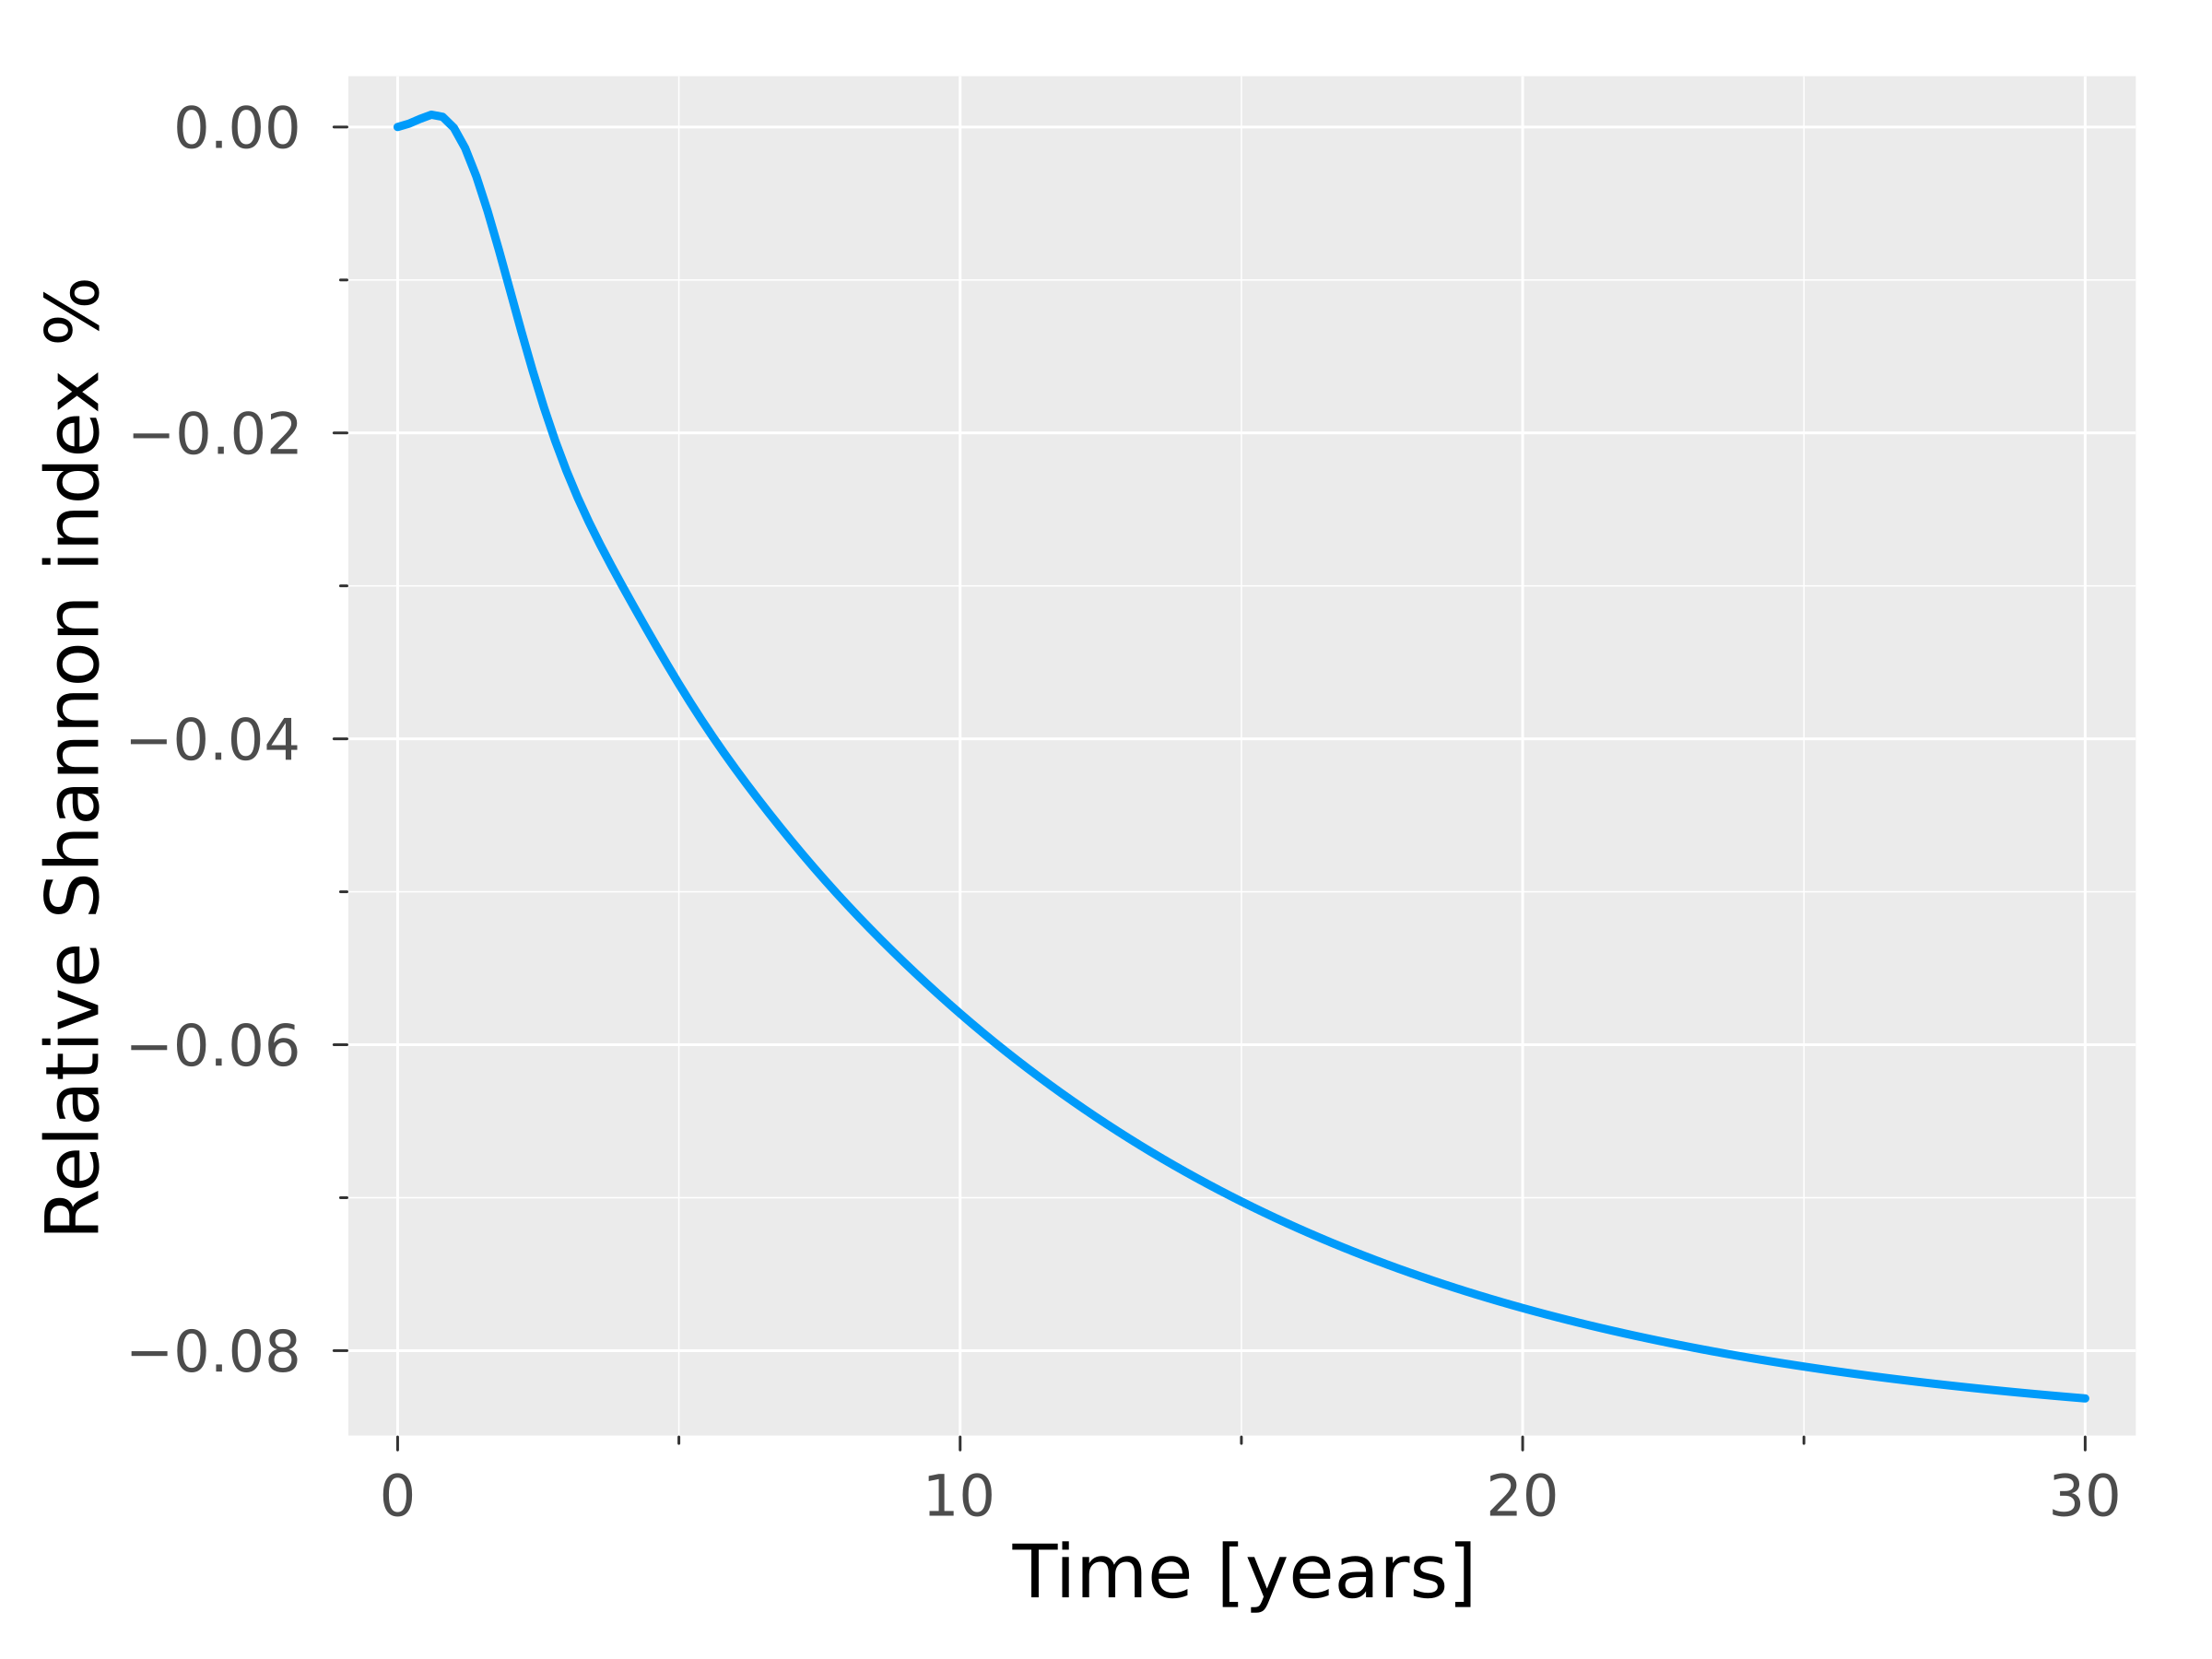

In [107]:
gr()
# plot(
#     time_baseline,
#     H_baseline,
#     label="Baseline",
#     yaxis = "Shannon index",
#     xaxis = "Time [years]",
#     size = [1000,600],
#     margin = 1Plots.cm,
#     dpi=300
# )
plot(
    time_hatchery,
    (H_hatchery .- H_baseline) ./ H_baseline * 100,
    label="Hatchery",
    yaxis = "Relative Shannon index %",
    xaxis = "Time [years]",
    legend = :none,
    size = [800,600],
    margin = 0.5Plots.cm,
    dpi=300
)

In [108]:
savefig("mizerShelf/Shannon.png")

"c:\\Users\\Scuff\\OneDrive\\Course Documents\\Lobster Hatchery\\Code\\analysis\\mizerShelf\\Shannon.png"

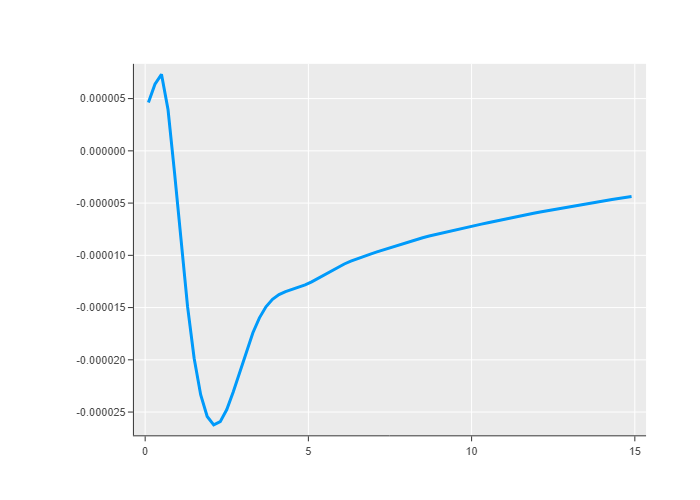

In [22]:
plot(time_hatchery[1:end-1] .+ 0.1, diff(H_hatchery))